<a href="https://colab.research.google.com/github/Vaishnavi943/bikee_rental_prediction_forecasting/blob/main/bike_rental_counting_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **bike_rental_counting_forecasting.ipynb**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math

In [2]:
df = pd.read_csv("hour.csv")

In [3]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [32]:
df.shape

(17379, 9)

**rename of columns**

In [6]:
df = df.rename(columns={"dteday": "date", "weathersit": "weather", "cnt": "count"})


df = df[["date", "hr", "season", "holiday", "weekday", "workingday", "weather", "count"]]

In [8]:
df.tail()

,date,hr,season,holiday,weekday,workingday,weather,count
17374,2012-12-31,19,1,0,1,1,2,119
17375,2012-12-31,20,1,0,1,1,2,89
17376,2012-12-31,21,1,0,1,1,1,90
17377,2012-12-31,22,1,0,1,1,1,61
17378,2012-12-31,23,1,0,1,1,1,49


** Convert date to datetime and numeric format**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        17379 non-null  object
 1   hr          17379 non-null  int64 
 2   season      17379 non-null  int64 
 3   holiday     17379 non-null  int64 
 4   weekday     17379 non-null  int64 
 5   workingday  17379 non-null  int64 
 6   weather     17379 non-null  int64 
 7   count       17379 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.1+ MB


In [10]:
df["datetime"] = pd.to_datetime(df["date"]) + pd.to_timedelta(df["hr"], unit="h")

df["date_num"] = pd.to_datetime(df["date"]).map(pd.Timestamp.toordinal)

In [11]:
df.set_index("datetime", inplace=True)

In [12]:
df = df.sort_index()

In [13]:
df.head()

,date,hr,season,holiday,weekday,workingday,weather,count,date_num
datetime,,,,,,,,,
2011-01-01 00:00:00,2011-01-01,0,1,0,6,0,1,16,734138
2011-01-01 01:00:00,2011-01-01,1,1,0,6,0,1,40,734138
2011-01-01 02:00:00,2011-01-01,2,1,0,6,0,1,32,734138
2011-01-01 03:00:00,2011-01-01,3,1,0,6,0,1,13,734138
2011-01-01 04:00:00,2011-01-01,4,1,0,6,0,1,1,734138


In [14]:
df.isnull().sum()

,0
date,0
hr,0
season,0
holiday,0
weekday,0
workingday,0
weather,0
count,0
date_num,0


<Axes: xlabel='datetime'>

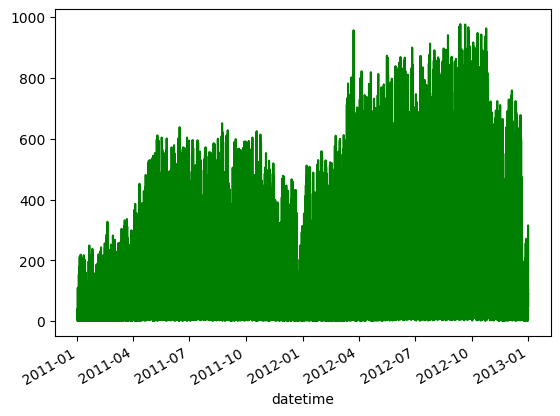

In [16]:
df['count'].plot(color='green')

**Check stationarity by doing ADFuller Test**

In [17]:
adf_result = adfuller(df["count"])

In [18]:
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -6.822918711895102
p-value: 1.980862627797737e-09


In [19]:
if adf_result[1] > 0.05:
    print("Null Hypothesis--------------> Data Not Stationary")
else:
    print("Rejecting Null Hypothesis--------------> Data is Stationary")

Rejecting Null Hypothesis--------------> Data is Stationary


**ACF and PACF plots**

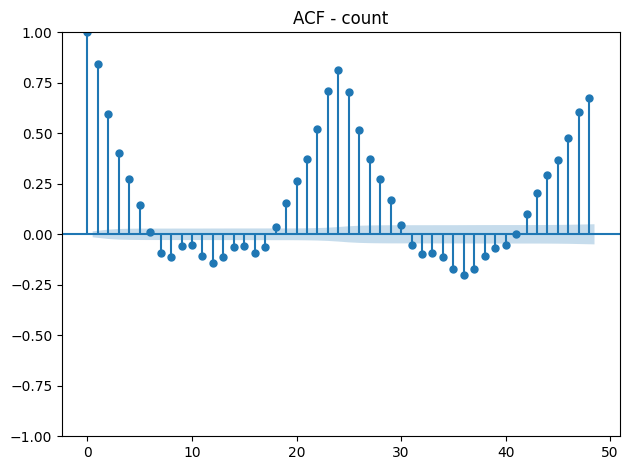

In [25]:

plot_acf(df["count"], lags=48)
plt.title("ACF - count")

plt.tight_layout()
plt.show()


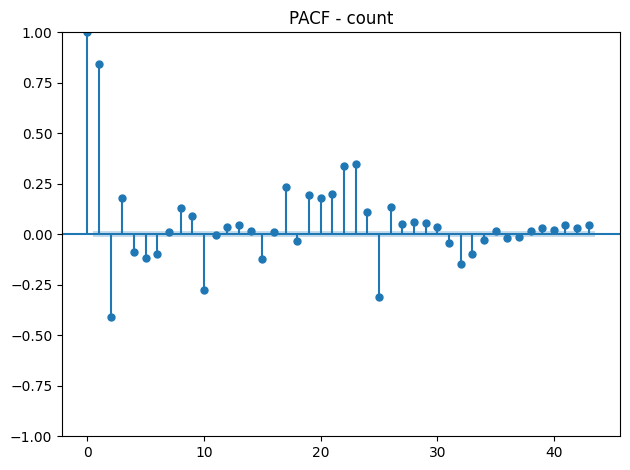

In [27]:

plot_pacf(df["count"])
plt.title("PACF - count")
plt.tight_layout()
plt.show()

**Split The Data**

In [28]:
features = ["season", "holiday", "weekday", "workingday", "weather", "hr", "date_num"]
X = df[features]
y = df["count"]

In [29]:
# Train-test split

split_index = int(len(y) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [31]:
X_train.shape

(13903, 7)

In [33]:
y_train.shape

(13903,)

In [34]:
y_test.shape

(3476,)

**Sarimax model**

In [40]:
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 0, 2),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=True,
    enforce_invertibility=True
)

In [ ]:
model_fit = model.fit(disp=False, maxiter=50)

**Forecasting**

In [37]:
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

In [38]:
y_pred

,predicted_mean
13903,210.035996
13904,220.141194
13905,215.311539
13906,203.598095
13907,295.252294
...,...
17374,-72.053728
17375,-74.617742
17376,-73.654988
17377,-76.219002


**Evaluation**

In [39]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 368.90


**Plot**

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred.values, label="Forecast")
plt.legend()
plt.title("Actual vs Forecasted Bike Count")
plt.xlabel("Datetime")
plt.ylabel("Bike Count")
plt.grid(True)
plt.show()